In [1021]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
import pybaselines
from sklearn.preprocessing import normalize as norm

In [1046]:
FILE_PATH = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0001_newcut.root" #Relative file path
file1 = uproot.open(FILE_PATH)
file1["tree"].show()

FILE_PATH_2 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0002_newcut.root" #Relative file path
file2 = uproot.open(FILE_PATH_2)

FILE_PATH_3 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0003_newcut.root" #Relative file path
file3 = uproot.open(FILE_PATH_3)

FILE_PATH_4 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0004_newcut.root" #Relative file path
file4 = uproot.open(FILE_PATH_4)

FILE_PATH_5 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0005_newcut.root" #Relative file path
file5 = uproot.open(FILE_PATH_5)

FILE_PATH_6 = "../Dati/Run_Na_ortho_468ps_trig_on_1200keV_Data_5_27_2024_Ascii_0000.root"
file6=uproot.open(FILE_PATH_6)

FILE_PATH_7 = "../Dati/Ortopositronio/Run_ortho2_468ps_Data_5_31_2024_Ascii_0000.root"
file7=uproot.open(FILE_PATH_7)

FILE_PATH_8 = "../Dati/Run_ortho2_468ps_Data_5_31_2024_Ascii_0001.root"
file8=uproot.open(FILE_PATH_8)

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [1055]:
print(type(file7["tree"]["base"].array()))
bl=file8["tree"]["base"].array()
#print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file2["tree"]["ch"].array()
print(nch)


<class 'awkward.highlevel.Array'>
[15]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [1024]:
def extract_data(file):
    baselines = np.array(file["tree"]["base"])[1:-1]
    charges = np.array(file["tree"]["charge"])[1:-1]
    amp = np.array(file["tree"]["amp"])[1:-1]
    lead_edge = np.array(file["tree"]["letime"])[1:-1]
    t_edge = np.array(file["tree"]["tetime"])[1:-1]
    channel = np.array(file["tree"]["ch"])[1:-1]
    waveform = np.array(file["tree"]["pshape"])[1:-1]
    
    return baselines, charges, amp, lead_edge, t_edge, channel, waveform

# Use the function for each batch
baselines1, charges1, amp1, lead_edge1, t_edge1, channel1, waveform1 = extract_data(file1)
baselines2, charges2, amp2, lead_edge2, t_edge2, channel2, waveform2 = extract_data(file2)
baselines3, charges3, amp3, lead_edge3, t_edge3, channel3, waveform3 = extract_data(file3)
baselines4, charges4, amp4, lead_edge4, t_edge4, channel4, waveform4 = extract_data(file4)
baselines5, charges5, amp5, lead_edge5, t_edge5, channel5, waveform5 = extract_data(file5)
baselines6, charges6, amp6, lead_edge6, t_edge6, channel6, waveform6 = extract_data(file6)
baselines7, charges7, amp7, lead_edge7, t_edge7, channel7, waveform7 = extract_data(file7)
baselines8, charges8, amp8, lead_edge8, t_edge8, channel8, waveform8 = extract_data(file8)

#concatenate arrays

baselines=np.concatenate((baselines1, baselines2, baselines3, baselines4, baselines5, baselines6, baselines7, baselines8))
charges = np.concatenate((charges1, charges2, charges3,charges4, charges5, charges6, charges7, charges8))
amp = np.concatenate((amp1, amp2, amp3, amp4, amp5, amp6, amp7, amp8))
lead_edge = np.concatenate((lead_edge1, lead_edge2, lead_edge3,lead_edge4, lead_edge5, lead_edge6, lead_edge7, lead_edge8))
t_edge = np.concatenate((t_edge1, t_edge2, t_edge3,t_edge4, t_edge5, t_edge6, t_edge7, t_edge8))
channel = np.concatenate((channel1, channel2, channel3,channel4, channel5, channel6, channel7, channel8))
waveform = np.concatenate((waveform1,waveform2, waveform3,waveform4, waveform5, waveform6, waveform7, waveform8))





In [1025]:
print(amp1[0].shape)
print(amp7[0].shape)
print(amp[0].shape, amp[-1].shape)

(16,)
(15,)
(16,) (15,)


In [1026]:
#carico la matrice degli offset
def load_matrix(filename):
    return(np.load(filename))

loaded=load_matrix('offset_matrix.npz')
matrix_loaded = loaded['arr_0']
print(matrix_loaded)

[[ 0.          1.97790006  8.30515642  5.13880779  3.25188705  0.60127363
   4.63887604  2.23860842  2.96122492  1.7662929   0.08214686  2.61439973
   5.75674346  0.          2.66775925  2.25991482]
 [-1.97790006  0.          6.65268982  3.35018406  1.62865816 -1.42310493
   3.35363686 -0.09357444  1.55745866 -0.03231273 -2.23996373  0.60939011
   4.72326522  0.          2.19416517  0.31886456]
 [-8.30515642 -6.65268982  0.         -3.16529453 -4.96229802 -7.97382458
  -3.7849691  -6.49220942 -5.17749042 -6.89120561 -8.45633986 -5.88758847
  -2.87454218 -1.5810066  -4.69470296 -6.61630156]
 [-5.13880779 -3.35018406  3.16529453  0.         -1.74554839 -4.80185979
  -0.55825317 -3.03106198 -1.99820973 -3.57586387 -4.96672159 -2.73908285
   0.62833715  0.         -1.49089966 -3.16862866]
 [-3.25188705 -1.62865816  4.96229802  1.74554839  0.         -3.28007198
   1.04874026 -1.23946888 -0.16332661 -2.06401735 -3.11165703 -1.13443192
   2.46599326  0.         -0.9021026  -1.78743256]
 [-0.

In [1027]:
print(amp.shape)
print(charges.shape)
print(len(amp))

(23042,)
(23042,)
23042


In [1028]:
len(np.where(amp[-10]>-1.2)[0])

15

In [1029]:
print(np.unique(np.array([len(amp[i]) for i in range(len(amp))])))
print([i for i in range(len(amp)) if len(amp[i]==15)])

[15 16]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [1030]:

mask=[len(np.where(amp[i]<=-1.2)[0])==0 for i in range(len(amp))]
print(mask)
baselines=baselines[mask]
charges=charges[mask]
amp=amp[mask]
lead_edge=lead_edge[mask]
t_edge=t_edge[mask]
channel=channel[mask]
waveform=waveform[mask]

[True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, False, True, True, True, True, False, False, True, False, False, True, True, True, False, True, True, True, True, False, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, False, True, True, False, False, False, False, True, True, False, False, True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, False, True, False, True, True, False, False, Tru

In [1031]:
print(len(amp))
Nev=len(amp)

16721


(16721,)
channel: 0 baseline: 7.6e-05 charge -1.064 lead_edge 250.959 trailing_edge 248.543
channel: 1 baseline: 0.000381 charge -0.423 lead_edge 370.578 trailing_edge 368.535
channel: 2 baseline: 0.000114 charge 0.2 lead_edge 29.735 trailing_edge 25.046
channel: 3 baseline: -0.000229 charge 1.659 lead_edge 332.058 trailing_edge 330.767
channel: 4 baseline: 0.000229 charge 0.343 lead_edge 35.509 trailing_edge 34.767
channel: 5 baseline: 0.0 charge 1.75 lead_edge 128.891 trailing_edge 127.469
channel: 6 baseline: 0.0 charge -0.538 lead_edge 303.118 trailing_edge 298.937
channel: 7 baseline: 0.000419 charge -2.517 lead_edge 351.031 trailing_edge 348.83
channel: 8 baseline: -0.000152 charge 3.294 lead_edge 89.125 trailing_edge 88.207
channel: 9 baseline: 3.8e-05 charge -483.089 lead_edge 0.003 trailing_edge 0.003
channel: 10 baseline: -0.008731 charge 4.496 lead_edge 264.481 trailing_edge 260.488
channel: 11 baseline: 0.0 charge -1.779 lead_edge 193.876 trailing_edge 189.309
channel: 12 b

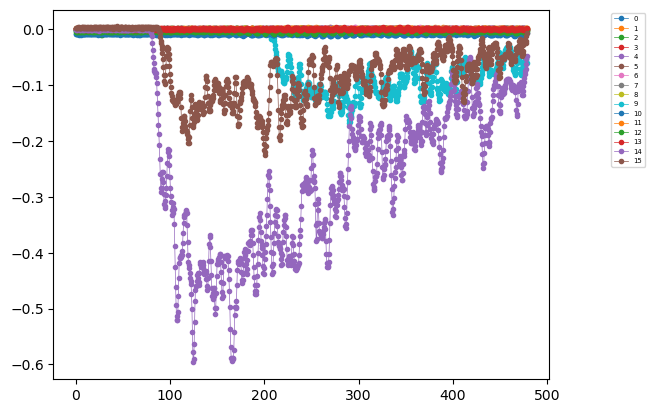

In [1032]:
print(waveform.shape)
event=521
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#list=[1,2,7,12]
sampling=0.468
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    #print(t1,t2)
    #plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60   )
    #plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60  )
    #plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))

In [1033]:
###pulizia
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
true_charges=[]
true_amps=[]
true_channels=[]
true_waveforms=[]
true_ledge=[]
for ev in range(Nev):
    interesting_channels=np.where(charges[ev]<-100)[0] #canali che hanno visto qualcosa
    true_channels.append(interesting_channels.tolist())
    true_charges.append([charges[ev][ch] for ch in interesting_channels])
    true_amps.append([amp[ev][ch] for ch in interesting_channels])
    true_waveforms.append([waveform[ev][ch] for ch in interesting_channels])
    true_ledge.append([lead_edge[ev][ch] for ch in interesting_channels])


#print(true_channels)
#print(true_charges)


#devo selezionare le annichilazioni back to back e isolarle dal resto


In [1034]:
#eventi con 3 gamma
n_photons=[len(true_channels[i]) for i in range(Nev)]
n_photons=np.array(n_photons)
three_gamma_events=np.where(n_photons == 4)[0] #eventi con 4 fotoni totali (ortopositronio?)
print(three_gamma_events)
four_gamma_events=np.where(n_photons == 5)[0]
print(four_gamma_events)

[   30    44    58 ... 16661 16691 16713]
[   36   176   747   749   782  1004  1383  2122  2139  2267  2276  2480
  2752  3209  3405  3832  4210  4239  4340  4435  4499  4573  4910  4915
  4927  5011  5219  5396  5660  5681  5801  5979  6017  6092  6114  6172
  6410  6414  6782  7042  7151  7598  7637  7847  8094  8309  8444  8488
  8565  8955  9031  9056  9271  9607  9765 10153 10350 10390 10534 10672
 10868 10888 10898 11049 11118 11161 11440 11496 11519 11911 12436 12533
 12565 12763 12943 13454 13457 14093 14151 14349 14431 14758 14876 14961
 14982 15305 15524 15695 15824 15834 16054 16235 16275 16388 16401 16469
 16530]


In [1035]:
shift = 5

def times_from_waveforms(wf_narr, n_conv, threshold):

    lenghts = []
    wf_arr = []

    for evt in range(len(wf_narr)):
        for ch in range(len(wf_narr[evt])):
            wf_arr.append(wf_narr[evt][ch])
        lenghts.append(len(wf_narr[evt]))


    wf_arr = np.array(wf_arr)
    wf_arr = -norm(-np.array(wf_arr), norm = "max", axis = 1, copy = True, return_norm = False)

    ledges = np.zeros(wf_arr.shape[0])


    for evt in range(len(wf_arr)):

        bsl = wf_arr[evt][0:32].mean()
        wf_arr[evt] = np.convolve(wf_arr[evt], [1/n_conv] * n_conv, mode = "same") - bsl

        ledge= np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]
        ledges[evt]=np.interp(threshold,  [wf_arr[evt][ledge-shift], wf_arr[evt][ledge+shift]], [ledge-shift, ledge+shift])*0.468

        #ledges[evt] = np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]

        

        #plt.plot(range(1024), wf_arr[evt])
        #plt.plot([ledges[evt]] * 2, [ -1, 0])


    ledg_arr = []
    k = 0
    for i in range(len(lenghts)):
        tmp_list = []
        for j in range(lenghts[i]):
            tmp_list.append(ledges[k])
            k += 1
        ledg_arr.append(tmp_list)


    return ledg_arr

print(0.468*1024) #finestra di sampling di wavecatcher



479.232


In [1036]:
#funzione per filtrare le coincidenze casuali

def filter_times(times, sigma):
    filtered_times = []
    threshold = 3 * sigma

    for time in times:
        if any(abs(time - other_time) <= threshold for other_time in times if other_time != time):
            filtered_times.append(time)
    
    return filtered_times

/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


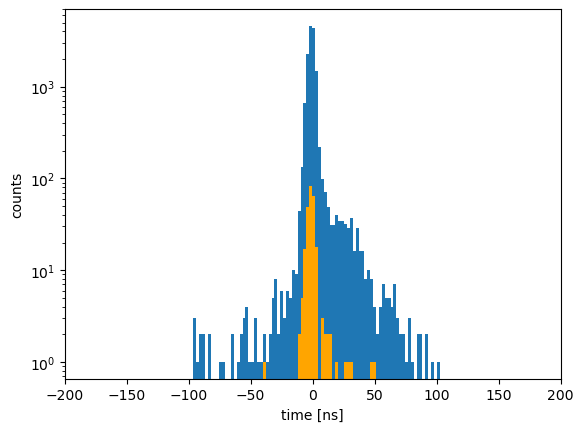

In [1037]:

good_t_arr=[]
time_diff=[]
back_to_back_times=[] #inserirò i tempi degli eventi back to back
treshold=-0.01 #soglia fissa
btb_pairs=[np.array([4,5]), np.array([6, 7]), np.array([8, 9]), np.array([10,11]), np.array([12, 13]), np.array([14, 15])]
timing_res = 1.7 #la nostra risoluzione temporale


arr_times_all=times_from_waveforms(true_waveforms,30, treshold)


for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=arr_times_all[ev] #calcolo tempi di arrivo dei segnali
    ev_is_good=(t_arr[index_1200]!=0)
    if(ev_is_good):
        good_t_arr.append(t_arr)
        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
        #add offset
        t_diff = [t_diff[i] - matrix_loaded[true_channels[ev][i]][true_channels[ev][index_1200]] for i in range(len(t_diff))]
        t_diff.pop(index_1200)
        
        #check if the low-energy photons are actually in coincidence
        t_diff=filter_times(t_diff, timing_res)
        if(len(t_diff) >=2):
            time_diff.append(t_diff)
            #if(np.mean(np.array(t_diff)) < -80): print(ev)


        # print(true_channels[ev])
        #if(np.mean(np.array(t_diff)) < -25): print(ev)
    
    
    gamma_channels = [ch for i, ch in enumerate(true_channels[ev]) if i != index_1200] #canali che hanno visto i fotoncini di annichilazione
    #print(gamma_channels)
    for pair in btb_pairs:
        if np.array_equal(sorted(gamma_channels), sorted(pair)):
            back_to_back_times.append(t_diff)
            break  # Exit loop if a match is found

    
        

#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff if -100< np.mean(np.array(times)) <200]  #taglio
mean_time_diff=np.array(mean_time_diff)

btb_mean_time_diff =[np.mean(np.array(times)) for times in back_to_back_times]
btb_mean_time_diff = np.array(btb_mean_time_diff)

bins_array = np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=2.34) # uncomment to go back to even bins

outofwindow=np.where(mean_time_diff > 0.468*1024)[0]
#print(outofwindow)

bin_T, edgesT, _=plt.hist(mean_time_diff, bins=bins_array)
_=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')
plt.yscale('log')

#pop away the first bin
#bin_T=bin_T[1:-1]
#edgesT=edgesT[1:-1]  #l'ultimo bin eccede la finestra di wavecatcher


#Nbins = len(np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=4))
Nbin=len(bin_T)


centersT = np.convolve(edgesT, [0.5, 0.5], "valid")
#plt.yscale('log')
plt.xlim(-200, 200)
plt.xlabel('time [ns]')
plt.ylabel('counts')

#evaluate errors

errT = np.sqrt(bin_T)
#print(edgesT)



In [1038]:
#proviamo a fittare
import lmfit
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, ConstantModel, LorentzianModel, VoigtModel, ThermalDistributionModel, StepModel, SkewedGaussianModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [1039]:

# Define the truncated exponential function
def myexp(x, amplitude, decay):
    x = np.asarray(x)  # Ensure x is a NumPy array
    result = np.zeros_like(x)
    mask = x >= 0
    result[mask] = amplitude * np.exp(-x[mask] / decay)
    return result



# Create models
exp1 = Model(myexp, independent_vars=['x'], prefix='e1_')
exp2 = Model(myexp, independent_vars=['x'], prefix='e2_')
gauss1 = GaussianModel(prefix='g1_')
#offset1 = StepModel(form = "logistic", prefix = "s1_")*(1 - StepModel(form = "logistic", prefix = "s2_"))
offset1 = ConstantModel(prefix='c1_')
#vincolo i parmetri della sigmoide:

##gauss1 = SkewedGaussianModel(prefix='g1_')
#gauss1 = VoigtModel(prefix='g1_')

# Combine models
model = exp1 + exp2 + gauss1 + offset1


# Initialize parameters
params = gauss1.guess(bin_T, x=centersT)
params.update(exp1.make_params(amplitude=1000, decay=3))
params.update(exp2.make_params(amplitude=1000, decay=100))
params.update(offset1.make_params(c=0.5))

# Update parameters
params["e1_amplitude"].min = 0
params["e2_amplitude"].min = 0
#params["g1_center"].set(min=-0.7, max=0.7)
params["e2_decay"].set(value=142)

# Ensure all parameters are properly initialized
#params["e1_amplitude"].set(value=1000, min=0)
#params["e1_decay"].set(value=1, min=0)
params["e2_amplitude"].set(value=500)
params["e2_decay"].set(value=100, min=0)
params["g1_amplitude"].set(value=8000, min=10)
params["g1_center"].set(value=0)
params["g1_sigma"].set(value=3, min=0)


#params["g1_gamma"].set(value=0, max=1, min=-1)


params["c1_c"].max = 2.5

result = model.fit(bin_T, params, x=centersT, weights=1 / errT, nan_policy='omit')

# Print fit report
print(result.fit_report())



[[Model]]
    (((Model(myexp, prefix='e1_') + Model(myexp, prefix='e2_')) + Model(gaussian, prefix='g1_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 199
    # data points      = 74
    # variables        = 8
    chi-square         = 213.516939
    reduced chi-square = 3.23510513
    Akaike info crit   = 94.4141795
    Bayesian info crit = 112.846700
    R-squared          = 0.99999536
[[Variables]]
    g1_amplitude:  29596.7783 +/- 1463.90635 (4.95%) (init = 8000)
    g1_center:    -0.98602053 +/- 0.15658209 (15.88%) (init = 0)
    g1_sigma:      2.61049470 +/- 0.07339513 (2.81%) (init = 3)
    g1_fwhm:       6.14724514 +/- 0.17283232 (2.81%) == '2.3548200*g1_sigma'
    g1_height:     4523.05335 +/- 147.584379 (3.26%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    e1_amplitude:  1654.18779 +/- 1555.28183 (94.02%) (init = 1000)
    e1_decay:      0.99288968 +/- 1.46385716 (147.43%) (init = 3)
    e2_amplitude:  10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


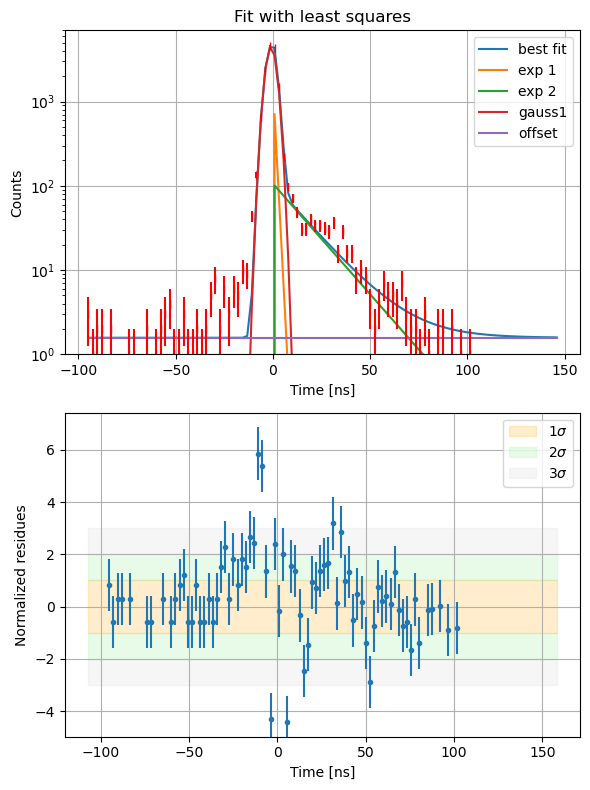

In [1043]:
#plot del fit

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersT, result.best_fit, label='best fit')
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')
ax1.plot(centersT, comps['g1_'], label='gauss1')
ax1.plot(centersT, comps['c1_'], label='offset')


ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
#ax1.set_xlim(0, 100)
ax1.grid()

residueT = bin_T - result.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax1.set_ylim(1, 7000)
ax1.set_yscale('log')

ax2.legend()

ax1.set_title('Fit with least squares')
fig.tight_layout()
plt.show()

In [1041]:
print(len(mean_time_diff))

14526


In [1042]:
emcee_kws = dict(steps=10000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee = model.fit(data=bin_T, x=centersT, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

emcee: Exception while calling your likelihood function:
  params: [ 3.05607186e+04 -8.00072228e-01  2.56965903e+00  1.69045333e+03
  5.89020278e-01  6.30012456e+01  2.51222397e+01  2.35139915e+00
  6.92940584e-01]
  args: (<bound method Model._residual of <lmfit.Model: (((Model(myexp, prefix='e1_') + Model(myexp, prefix='e2_')) + Model(gaussian, prefix='g1_')) + Model(constant, prefix='c1_'))>>, Parameters([('g1_amplitude', <Parameter 'g1_amplitude', value=30560.718615909656, bounds=[10:inf]>), ('g1_center', <Parameter 'g1_center', value=-0.7961087033726983, bounds=[-inf:inf]>), ('g1_sigma', <Parameter 'g1_sigma', value=2.5689978062559575, bounds=[0:inf]>), ('g1_fwhm', <Parameter 'g1_fwhm', value=6.049527414127654, bounds=[-inf:inf], expr='2.3548200*g1_sigma'>), ('g1_height', <Parameter 'g1_height', value=4746.780815828426, bounds=[-inf:inf], expr='0.3989423*g1_amplitude/max(1e-15, g1_sigma)'>), ('e1_amplitude', <Parameter 'e1_amplitude', value=1807.0056346493132, bounds=[0:inf]>), ('

Traceback (most recent call last):
  File "/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/lmfit/minimizer.py", line 1064, in _lnprob
    params[name].value = val
  File "/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/lmfit/parameter.py", line 960, in value
    if not hasattr(self, '_expr_eval'):
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
print(result_emcee.fit_report())

[[Model]]
    (((Model(myexp, prefix='e1_') + Model(myexp, prefix='e2_')) + Model(gaussian, prefix='g1_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 104
    # variables        = 9
    chi-square         = 9545.85147
    reduced chi-square = 100.482647
    Akaike info crit   = 488.024988
    Bayesian info crit = 511.824506
    R-squared          = 0.99979251
[[Variables]]
    g1_amplitude:  30603.0289 +/- 21.5314736 (0.07%) (init = 29596.78)
    g1_center:    -0.79855442 +/- 0.00225147 (0.28%) (init = -0.9860205)
    g1_sigma:      2.57373045 +/- 0.00146625 (0.06%) (init = 2.610495)
    g1_fwhm:       6.06067194 == '2.3548200*g1_sigma'
    g1_height:     4743.63690 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    e1_amplitude:  2089.21759 +/- 497.325861 (23.80%) (init = 1654.188)
    e1_decay:      0.51343760 +/- 0.07162707 (13.95%) (init = 0.9928897)
    e2_amplitude:  62.4568240 +/- 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


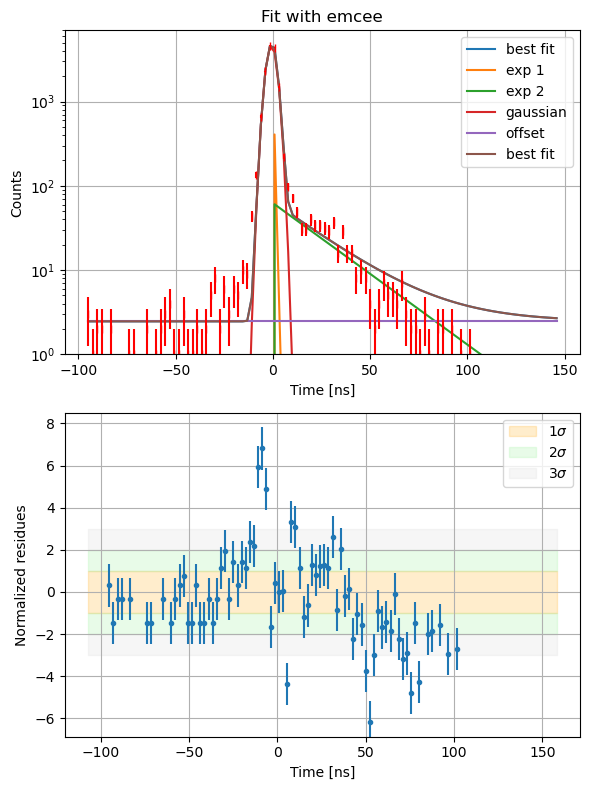

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result_emcee.eval_components() 
ax1.plot(centersT, result_emcee.best_fit, label='best fit')                       #Plotto il best fit + le componenti
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')
ax1.plot(centersT, comps['g1_'], label='gaussian')
ax1.plot(centersT, comps['c1_'], label='offset')
ax1.plot(centersT, result_emcee.best_fit, label='best fit')

ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
#ax1.set_xlim(0, 200)
ax1.grid()

residueT = bin_T - result_emcee.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
ax1.set_yscale('log')
ax2.legend()
ax1.set_ylim(1, 7000)
ax1.set_title('Fit with emcee')
fig.tight_layout()
plt.show()

nan
[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 18
    # variables        = 2
    chi-square         = 253.000000
    reduced chi-square = 15.8125000
    Akaike info crit   = 51.5743192
    Bayesian info crit = 53.3550627
    R-squared          = 0.98094238
##  Warning: uncertainties could not be estimated:
    e1_amplitude:  at initial value
    e1_amplitude:  at boundary
    e1_decay:      at initial value
[[Variables]]
    e1_amplitude:  8.1557e-13 (init = 8.156227e-13)
    e1_decay:      4.00000000 (init = 4)
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [333.57024079          nan  58.134035  ]


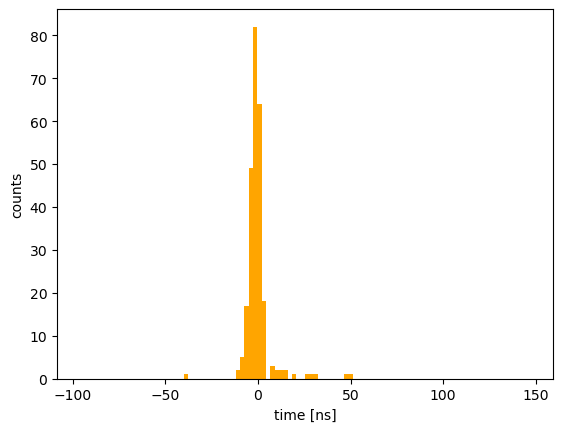

In [ ]:
#fitto solo la componente back to back

bin_btb, edges_btb, _=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')

print(np.min(btb_mean_time_diff))

#bin_btb=bin_btb[1:-1]
#edges_btb=edges_btb[1:-1]  

centers_btb = np.convolve(edges_btb, [0.5, 0.5], "valid")
plt.xlabel('time [ns]')
plt.ylabel('counts')
err_btb = np.sqrt(bin_btb)

exp1   = ExponentialModel(prefix='e1_')

model = exp1 

params = exp1.guess(bin_btb, x=centers_btb)  
params["e1_amplitude"].min = 0
params["e1_decay"].set(value=4)

result = model.fit(bin_btb, params, x = centers_btb, weights = 1 / err_btb,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_btb = model.fit(data=bin_btb, x=centers_btb, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

In [ ]:
print(result_emcee_btb.fit_report())

[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 104
    # variables        = 3
    chi-square         = 3320.46126
    reduced chi-square = 32.8758541
    Akaike info crit   = 366.200681
    Bayesian info crit = 374.133854
    R-squared          = 0.74988106
[[Variables]]
    e1_amplitude:  2.43310608 +/- 0.23652796 (9.72%) (init = 8.155698e-13)
    e1_decay:      8.8614e+18 +/- 3.185e+148 (359465572167489341621022802701437215122474520737147034588776106741845612556450261460264904410718642511169985438041140817340022128640.00%) (init = 4)
    __lnsigma:     0.69290935 +/- 3.5325e-04 (0.05%) (init = -2.302585)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


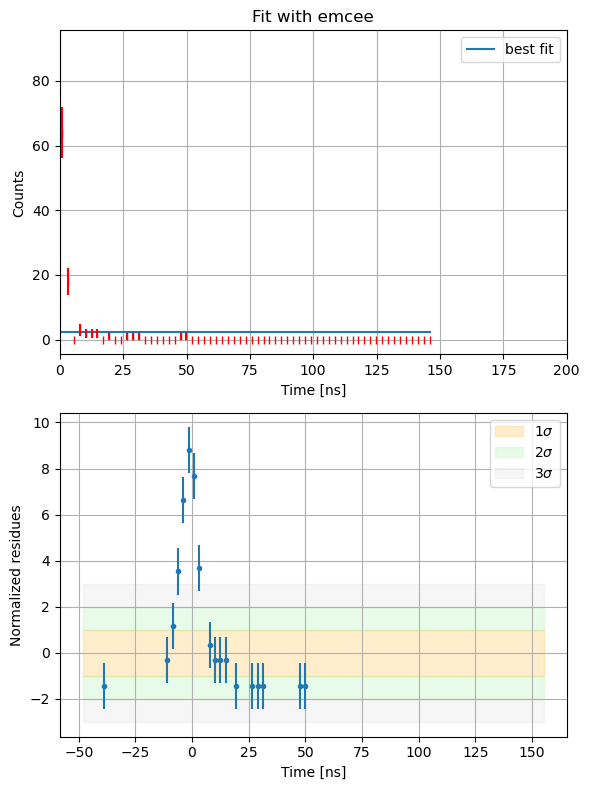

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(centers_btb, result_emcee_btb.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(centers_btb, bin_btb, err_btb, color = "red", fmt='|')
ax1.set_xlim(0, 200)
ax1.grid()

residue_btb = bin_btb - result_emcee_btb.best_fit
norm_res_btb = residue_btb / err_btb

ax2.errorbar(centers_btb, norm_res_btb, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
#ax1.set_ylim(1, 1000)
ax1.set_title('Fit with emcee')
fig.tight_layout()

[[Model]]
    (Model(myexp, prefix='e1_') + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 71
    # variables        = 5
    chi-square         = 7560.04879
    reduced chi-square = 114.546194
    Akaike info crit   = 341.424666
    Bayesian info crit = 352.738066
    R-squared          = 0.99982981
[[Variables]]
    e1_amplitude:  7224.32798 +/- 1505.17764 (20.83%) (init = 1000)
    e1_decay:      1.67372801 +/- 0.29215972 (17.46%) (init = 100)
    g1_amplitude:  2097.39266 +/- 887.688169 (42.32%) (init = 1000)
    g1_center:     10.8878601 +/- 6.74270024 (61.93%) (init = 0)
    g1_sigma:      17.5082965 +/- 5.19018990 (29.64%) (init = 5)
    g1_fwhm:       41.2288861 +/- 12.2219629 (29.64%) == '2.3548200*g1_sigma'
    g1_height:     47.7909809 +/- 27.1682488 (56.85%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(e1_amplitude, e1_dec

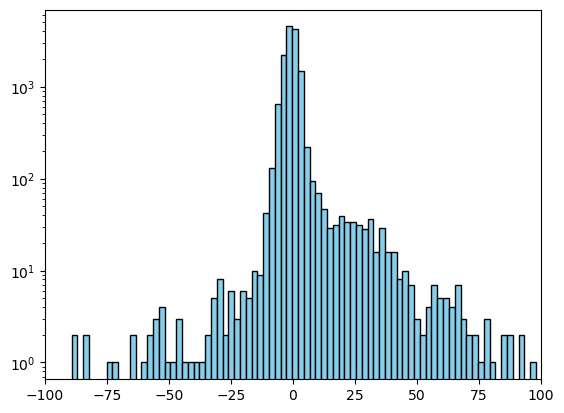

In [ ]:
#isolo la componente a 3 fotoni

three_gamma_ortho=bin_T - bin_btb
three_gamma_edges=edgesT

three_gamma_ortho = three_gamma_ortho[3:]
three_gamma_edges = three_gamma_edges[3:]

#print(three_gamma_ortho, three_gamma_edges)
three_gamma_centers = np.convolve(three_gamma_edges, [0.5, 0.5], "valid")
three_g_err=np.sqrt(three_gamma_ortho)
plt.bar(three_gamma_edges[:-1], three_gamma_ortho, width=(three_gamma_edges[1] - three_gamma_edges[0]),align='edge', color='skyblue', edgecolor='black')
plt.xlim(-100,100)
plt.yscale('log')
exp1   = Model(myexp, independent_vars=['x'], prefix='e1_')
gauss1 = GaussianModel(prefix='g1_')
#gauss1 = VoigtModel(prefix='g1_')

model = exp1 + gauss1

params.update(gauss1.make_params(amplitude=1000, sigma=5, center=0))
params.update(exp1.make_params(amplitude=1000, decay=100))
params["e1_amplitude"].min = 0

result = model.fit(three_gamma_ortho, params, x = three_gamma_centers, weights = 1 / three_g_err,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_3g = model.fit(data=three_gamma_ortho, x=three_gamma_centers, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)


In [ ]:
print(result_emcee_3g.fit_report())

[[Model]]
    (Model(myexp, prefix='e1_') + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 101
    # variables        = 6
    chi-square         = 13055.0827
    reduced chi-square = 137.421923
    Akaike info crit   = 503.043042
    Bayesian info crit = 518.733765
    R-squared          = 0.99970611
[[Variables]]
    e1_amplitude:  4031.06056 +/- 1748.52151 (43.38%) (init = 7224.328)
    e1_decay:      0.36450946 +/- 0.07665695 (21.03%) (init = 1.673728)
    g1_amplitude:  30483.2394 +/- 17.6529434 (0.06%) (init = 2097.393)
    g1_center:    -0.75334206 +/- 0.00186335 (0.25%) (init = 10.88786)
    g1_sigma:      2.59928823 +/- 0.00143442 (0.06%) (init = 17.5083)
    g1_fwhm:       6.12085591 == '2.3548200*g1_sigma'
    g1_height:     4678.60913 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    __lnsigma:     0.69308544 +/- 8.8547e-05 (0.01%) (init = -2.302585)
[[Correlations]] (unreported cor

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


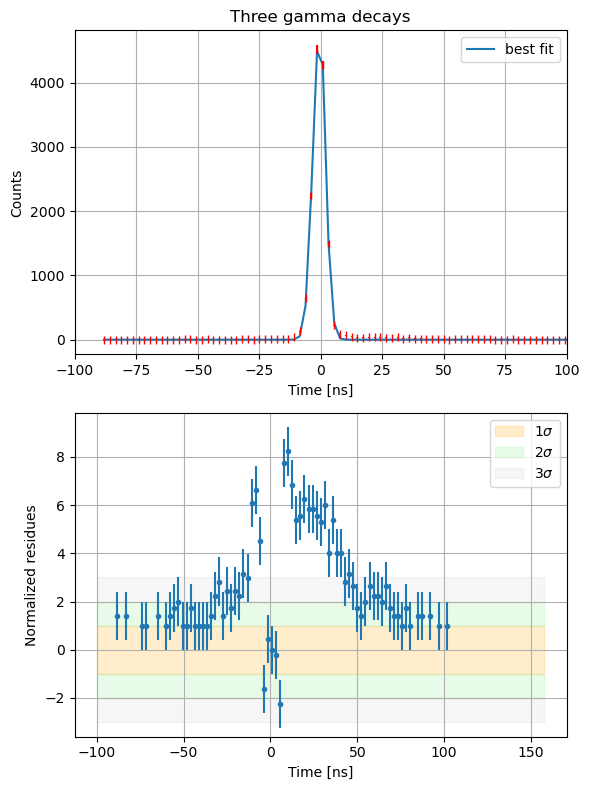

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(three_gamma_centers, result_emcee_3g.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(three_gamma_centers, three_gamma_ortho, three_g_err, color = "red", fmt='|')
ax1.set_xlim(-100, 100)
ax1.grid()

residue_3g = three_gamma_ortho - result_emcee_3g.best_fit
norm_res_3g = residue_3g / three_g_err

ax2.errorbar(three_gamma_centers, norm_res_3g, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
ax1.set_title('Three gamma decays')
fig.tight_layout()

# Un po' di speculazioni da strutturista secondo il modello di Tao-Eldrup

In [ ]:
delta = 0.166 #nm
lambdabar = 2.01 #ns^-1
lambda_po= 1/result_emcee_btb.params["e1_decay"].value #ns^-1
tau_po = result_emcee_btb.params["e1_decay"].value #ns
Rc = (tau_po + 5.07)/1.88
print(Rc)

4.71350240693019e+18


Original number of bins: 300
Symmetrized number of bins: 150
Filtered number of edges: 151
Final number of bins: 150
Final number of edges: 151


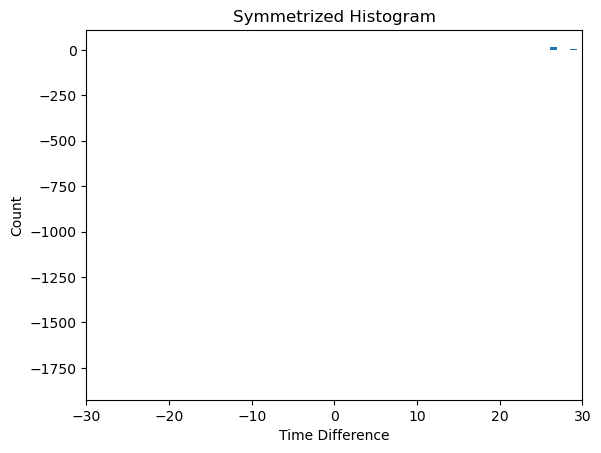

In [ ]:

mean_time_diff = np.array([tdiff for tdiff in mean_time_diff if -300 < tdiff < 300])

# Compute the histogram with 300 bins
bin_T_new, edgesT_new, _ = plt.hist(mean_time_diff, bins=300)
plt.close()  # Close the plot to avoid displaying it

print(f'Original number of bins: {len(bin_T_new)}')

# Initialize the symmetrized bin list
bin_T_new_symmetrized = []

# Calculate the symmetrized bin counts by summing symmetric bins around the center
# Leaving the central bin unaltered
central_bin_index = 149
bin_T_new_symmetrized.append(bin_T_new[central_bin_index])
for i in range(central_bin_index):
    sym_value = (bin_T_new[central_bin_index + i] - bin_T_new[central_bin_index - i]) 
    bin_T_new_symmetrized.append(sym_value)  

print(f'Symmetrized number of bins: {len(bin_T_new_symmetrized)}')

# Filter the edges to keep only those that are non-negative
edgesT_new_filtered = edgesT_new[central_bin_index+1:]

print(f'Filtered number of edges: {len(edgesT_new_filtered)}')

print(f'Final number of bins: {len(bin_T_new_symmetrized)}')
print(f'Final number of edges: {len(edgesT_new_filtered)}')

# Plot the histogram using plt.bar
plt.bar(edgesT_new_filtered[:-1], bin_T_new_symmetrized, width=edgesT_new_filtered[1]-edgesT_new_filtered[0], align='edge')
plt.xlim(-30,30)
plt.xlabel('Time Difference')
plt.ylabel('Count')
plt.title('Symmetrized Histogram')
plt.show()

